# Simple Demo

In [7]:
import os
import random

import pytorch_lightning as pl
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from covidx.dataset.dataset import CovidxDataset
from covidx.models import (ConvNetXray, DenseNetCovidX, EfficientNetCovidXray,
                           ResnetCovidX, XRayClassification)

In [3]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    
def create_test_transform(img_size, grayscale):

    resize = transforms.Resize((img_size, img_size))

    transform_list = []

    if grayscale:
        normalize = transforms.Normalize((0.5, ), (0.5, ))
        transform_list.append(transforms.Grayscale())
    else:
        normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])

    transform_list.extend([resize, transforms.ToTensor(), normalize])

    return transforms.Compose(transform_list)

In [11]:
CLS_MAPPING = ['COVID-19', 'normal', 'pneumonia']
IMG_SIZE = 320
GRAYSCALE = False
TEST_TRANSFORM = create_test_transform(IMG_SIZE, GRAYSCALE)

@torch.no_grad()
def get_single_prediction(model, img_path):




    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Get prediction
    
    img = pil_loader(img_path)
    img_tensor = TEST_TRANSFORM(img)
    img_tensor = img_tensor.to(device).unsqueeze(0)
    logit = model(img_tensor)
    pred = torch.argmax(F.log_softmax(logit, dim=1), dim=1).item()
    pred_str = CLS_MAPPING[pred]
    
    return pred_str

In [5]:
# Load model checkpoint
backbone = DenseNetCovidX(version='161')
ckpt_path =  "./lightning_logs/version_79/checkpoints/epoch=41-step=33011.ckpt"
model = XRayClassification.load_from_checkpoint(ckpt_path, map_location=lambda storage, loc: storage, model=backbone)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/eddie/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


../data/covidx_image_folder/test/COVID-19/covid-19-pneumonia-15-PA.jpg


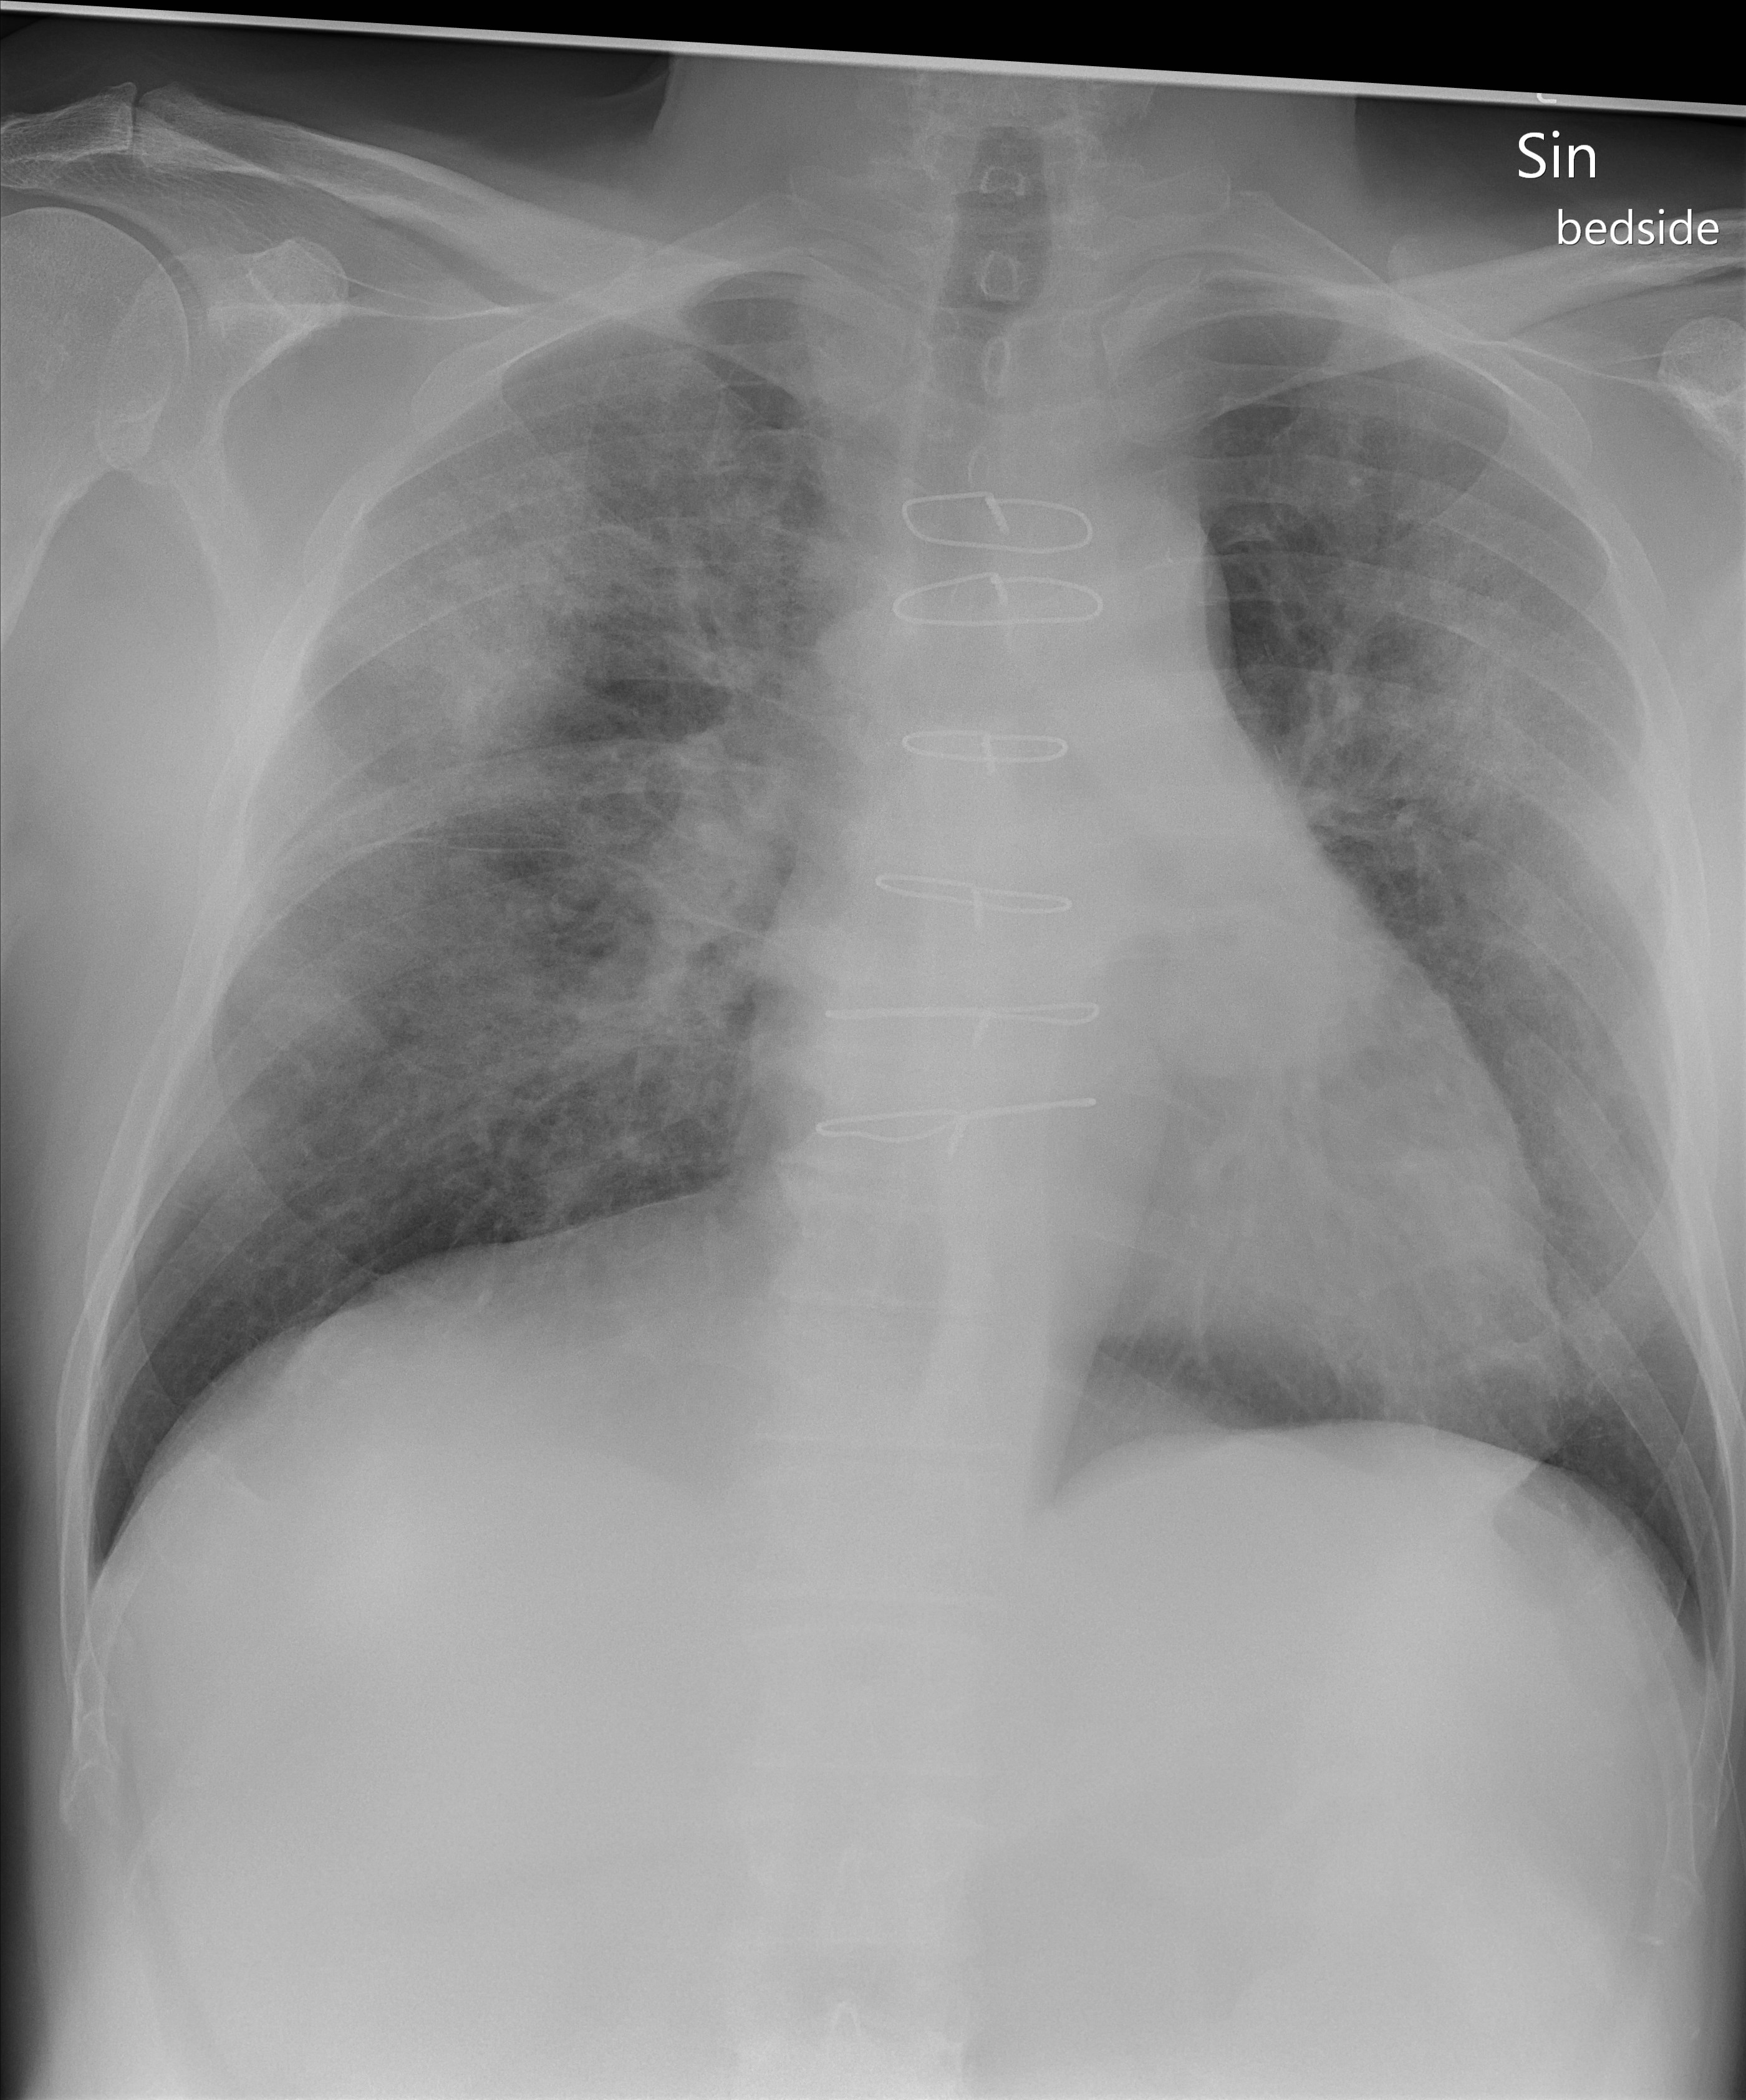

In [15]:
test_folder ='../data/covidx_image_folder/test/COVID-19/'
test_samples = [os.path.join(test_folder, x) for x in os.listdir(test_folder)]

# Choose a random test sample and display
img_path = random.choice(test_samples)

print(img_path)

display(Image.open(img_path))

In [16]:
pred = get_single_prediction(model, img_path)
print("Prediction:", pred)

Prediction: COVID-19
